# 📢 File explanation!!
Di dalam file ini, saya akan menggunakan perpustakaan `datasets` dari Huggingface untuk memuat dataset RAVDESS. Setelah itu, saya akan mengonversi data tersebut menjadi DataFrame dan menyimpannya dalam format .CSV. Langkah ini dilakukan agar mempermudah analisis data eksploratori (Exploratory Data Analysis/EDA) pada tahapan selanjutnya.

# 🎯 **Step 0: Import library**
---

In [81]:
# import gradio as gr
# import numpy as np
# import evaluate


# from datasets import load_dataset, Audio
# from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import keras
import tensorflow as tf
import seaborn as sns


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from IPython.display import Audio

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop, Adam


# 🎯 **Step 1: Load dataset after augmentation**
---

In [82]:
df_voice = pd.read_csv('./Dataset/df_combined.csv')

df_voice.head()

,Path,Emotion
0,./Dataset/Audio/Speech_RAVDESS\Actor_01\03-01-...,neutral
1,./Dataset/Audio/Speech_RAVDESS\Actor_01\03-01-...,neutral
2,./Dataset/Audio/Speech_RAVDESS\Actor_01\03-01-...,neutral
3,./Dataset/Audio/Speech_RAVDESS\Actor_01\03-01-...,neutral
4,./Dataset/Audio/Speech_RAVDESS\Actor_01\03-01-...,calm


In [83]:
df_voice['Emotion'].value_counts()

Emotion
happy        752
sad          752
angry        752
neutral      716
fearful      652
disgust      652
surprised    652
calm         192
Name: count, dtype: int64

In [84]:
df_voice = df_voice[df_voice['Emotion'] != 'calm']
df_voice = df_voice[df_voice['Emotion'] != 'fearful'] # = angry
df_voice = df_voice[df_voice['Emotion'] != 'disgust'] # 
df_voice = df_voice[df_voice['Emotion'] != 'surprised'] # = happy

In [85]:
df_voice['Emotion'].value_counts()

Emotion
happy      752
sad        752
angry      752
neutral    716
Name: count, dtype: int64

In [86]:
path = np.array(df_voice.Path)[100]
data, sample_rate = librosa.load(path)

sample_rate

22050

In [87]:
def noise(data):
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def time_shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def pitch_change(data, sampling_rate):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=0.8)

def higher_speed(data):
    return librosa.effects.time_stretch(y=data, rate=1.25)

def lower_speed(data):
    return librosa.effects.time_stretch(y=data, rate=0.75)

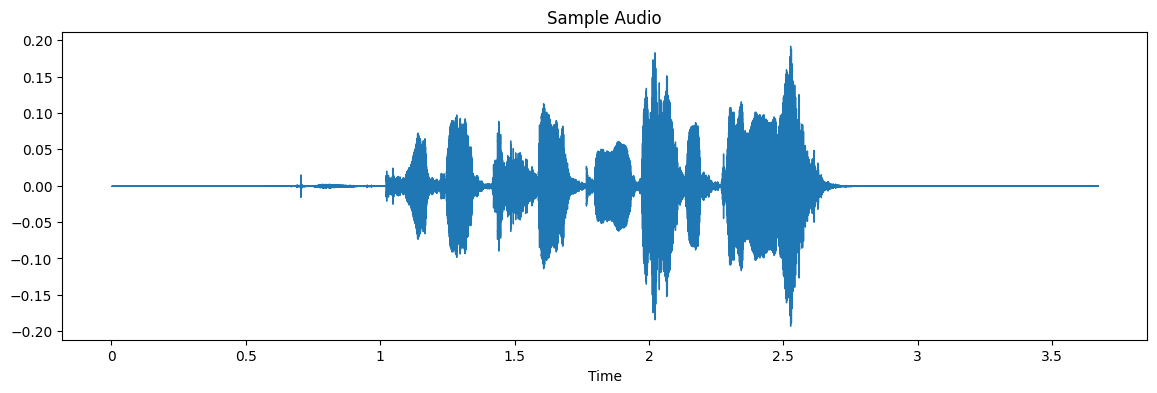

In [88]:
plt.figure(figsize=(14,4))
plt.title('Sample Audio')
librosa.display.waveshow(y=data, sr=sample_rate)
display(Audio(path))

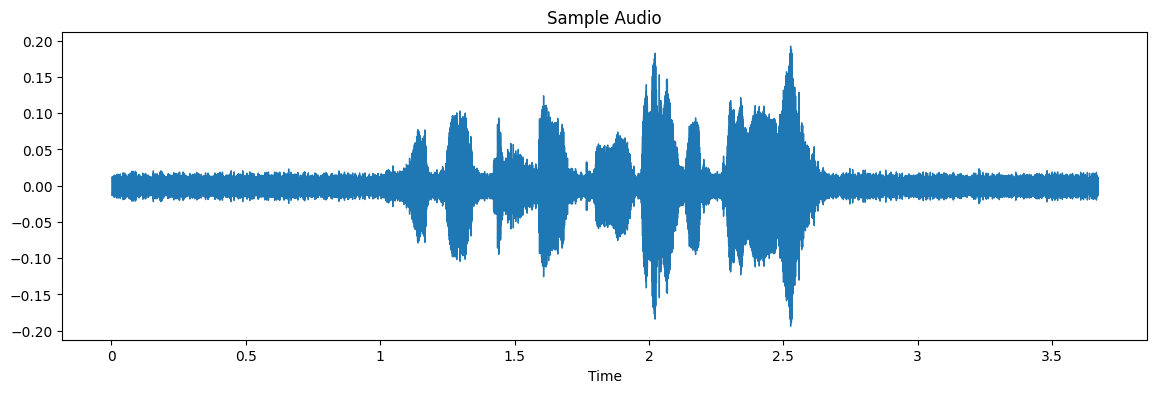

In [89]:
x = noise(data)
plt.figure(figsize=(14,4))
plt.title('Sample Audio')
librosa.display.waveshow(y=x, sr=sample_rate)
display(Audio(path))

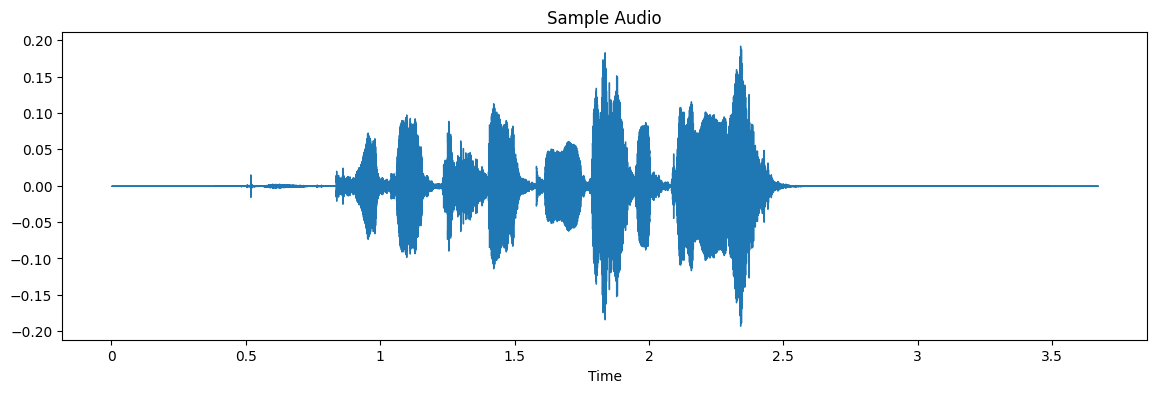

In [90]:
x = time_shift(data)
plt.figure(figsize=(14,4))
plt.title('Sample Audio')
librosa.display.waveshow(y=x, sr=sample_rate)
display(Audio(path))

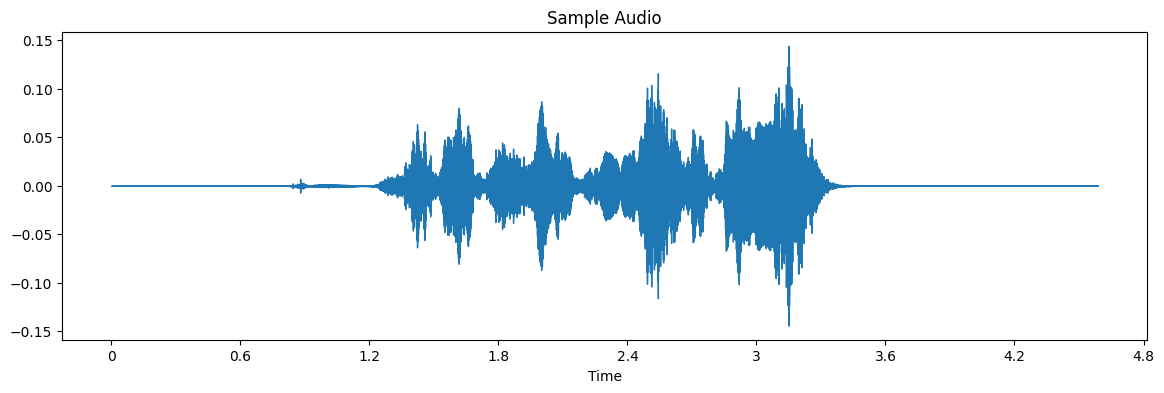

In [91]:
x = stretch(data)
plt.figure(figsize=(14,4))
plt.title('Sample Audio')
librosa.display.waveshow(y=x, sr=sample_rate)
display(Audio(path))

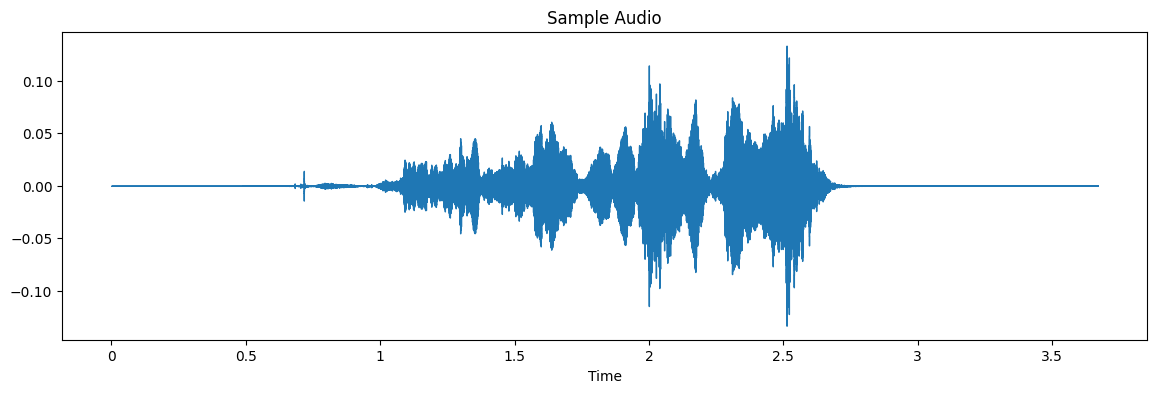

In [92]:
x = pitch_change(data, sample_rate)
plt.figure(figsize=(14,4))
plt.title('Sample Audio')
librosa.display.waveshow(y=x, sr=sample_rate)
display(Audio(path))

In [93]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [94]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    timeshift_data = time_shift(data)
    res3 = extract_features(timeshift_data)
    result = np.vstack((result, res3))

    speedchange_data = stretch(data)
    res4 = extract_features(speedchange_data)
    result = np.vstack((result, res4))

    pitchchange_data = pitch_change(data, sample_rate)
    res5 = extract_features(pitchchange_data)
    result = np.vstack((result, res5))

    highspeed_data = higher_speed(data)
    res6 = extract_features(highspeed_data)
    result = np.vstack((result, res6))

    lowerspeed_data = lower_speed(data)
    res7 = extract_features(lowerspeed_data)
    result = np.vstack((result, res7))
    
    return result

In [95]:
X, Y = [], []
for path, emotion in zip(df_voice.Path, df_voice.Emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [96]:
# X.shape, Y.shape

In [97]:
len(X), len(Y), df_voice.Path.shape

(20804, 20804, (2972,))

In [98]:
# Features = pd.read_csv('./features_without_calm_512.csv')

# Features.head()

In [99]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('./Features/features_lstm.csv', index=False)
Features

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.321275,0.729664,0.750033,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753972,...,0.000004,0.000003,2.148075e-06,0.000002,5.116493e-06,0.000008,0.000007,0.000005,4.245834e-07,neutral
1,0.329644,0.812227,0.842488,0.818939,0.817773,0.826914,0.705060,0.680788,0.741229,0.776480,...,0.000103,0.000109,1.025398e-04,0.000106,1.073939e-04,0.000113,0.000109,0.000110,1.017026e-04,neutral
2,0.320629,0.740885,0.739738,0.723335,0.736451,0.681295,0.652557,0.701629,0.746103,0.748172,...,0.000004,0.000003,2.148074e-06,0.000002,5.116453e-06,0.000008,0.000007,0.000005,4.245776e-07,neutral
3,0.173025,0.674528,0.752073,0.725325,0.729231,0.728289,0.665119,0.660569,0.720074,0.758500,...,0.000002,0.000001,9.037616e-07,0.000001,2.595818e-06,0.000004,0.000003,0.000002,2.633245e-07,neutral
4,0.187771,0.680198,0.720626,0.727919,0.707194,0.688234,0.673348,0.659386,0.664930,0.744040,...,0.000001,0.000002,1.496186e-06,0.000001,8.177922e-07,0.000001,0.000003,0.000002,1.389039e-07,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20799,0.037616,0.575086,0.577237,0.562004,0.570100,0.655525,0.603991,0.576511,0.597024,0.689009,...,0.050847,0.014289,2.220202e-02,0.013023,6.480091e-03,0.004530,0.003130,0.001492,5.508084e-04,sad
20800,0.041222,0.565385,0.569021,0.548078,0.564468,0.637939,0.590401,0.566371,0.592487,0.721180,...,0.022199,0.005359,9.957036e-03,0.006348,3.209681e-03,0.001815,0.001382,0.000612,5.843720e-05,sad
20801,0.045058,0.645777,0.571416,0.572768,0.525071,0.534103,0.641070,0.588403,0.565173,0.587668,...,0.010625,0.017373,2.156193e-02,0.006799,9.000747e-03,0.003975,0.001789,0.001154,7.825267e-05,sad
20802,0.043039,0.665222,0.576201,0.592169,0.530553,0.608995,0.664258,0.590545,0.585463,0.617176,...,0.017870,0.005827,8.516344e-03,0.004614,2.411248e-03,0.001785,0.001206,0.000435,2.571107e-05,sad


In [100]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [101]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [117]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16643, 162), (16643, 4), (4161, 162), (4161, 4))

In [118]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16643, 162), (16643, 4), (4161, 162), (4161, 4))

In [119]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16643, 162, 1), (16643, 4), (4161, 162, 1), (4161, 4))

In [113]:
# x_train = np.expand_dims(x_train, axis=2)
# x_test = np.expand_dims(x_test, axis=2)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16643, 162, 1, 1), (16643, 4), (4161, 162, 1, 1), (4161, 4))

In [120]:
x_train.shape

(16643, 162, 1)

In [136]:
def model(x_train):
    model=Sequential()
    model.add(Conv1D(512, kernel_size=6, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))

    model.add(Conv1D(256, kernel_size=6, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling1D(pool_size=4, strides=2, padding='same'))

    model.add(Conv1D(128, kernel_size=6, strides=1, padding='same', activation='relu'))
    model.add(Conv1D(128, kernel_size=6, strides=1, padding='same', activation='relu'))
    model.add(Conv1D(128, kernel_size=6, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling1D(pool_size=4, strides=2, padding='same'))

    model.add(Conv1D(64, kernel_size=6, strides=1, padding='same', activation='relu'))
    model.add(Conv1D(64, kernel_size=6, strides=1, padding='same', activation='relu'))

    model.add(Flatten())

    model.add(Dense(units=4, activation='softmax'))

    opt = Adam(lr = 0.0001)
    model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    return model

In [137]:
model = model(x_train)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 162, 512)          3584      
                                                                 
 conv1d_10 (Conv1D)          (None, 162, 256)          786688    
                                                                 
 batch_normalization_2 (Bat  (None, 162, 256)          1024      
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 81, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 81, 128)           196736    
                                                                 
 conv1d_12 (Conv1D)          (None, 81, 128)          

In [138]:
result_path = './Result'

class Callback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > 0.96 and logs.get('val_accuracy') > 0.96):
            print("\nReached 99% accuracy") 
            self.model.stop_training = True 
     
callbacks = Callback()

checkpoint = tf.keras.callbacks.ModelCheckpoint(result_path + f'/features_maxpool.h5', 
        monitor='val_accuracy', verbose=1, 
        save_best_only=True, mode='max')

In [139]:
epoch = 50
history=model.fit(x_train, y_train, 
                  batch_size=32, epochs=epoch,
#                   steps_per_epoch=50,
                  validation_data=(x_test, y_test), callbacks=[callbacks, checkpoint])

Epoch 1/50
521/521 [==============================] - ETA: 0s - loss: 0.5105 - accuracy: 0.7956
Epoch 1: val_accuracy improved from -inf to 0.83802, saving model to ./Result\features_maxpool.h5
521/521 [==============================] - 178s 334ms/step - loss: 0.5105 - accuracy: 0.7956 - val_loss: 0.4060 - val_accuracy: 0.8380


c:\Users\LENOVO YOGA\Music\FINAL PROJECT\finalproject\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
521/521 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.8810
Epoch 2: val_accuracy improved from 0.83802 to 0.88200, saving model to ./Result\features_maxpool.h5
521/521 [==============================] - 194s 372ms/step - loss: 0.3019 - accuracy: 0.8810 - val_loss: 0.2819 - val_accuracy: 0.8820
Epoch 3/50
521/521 [==============================] - ETA: 0s - loss: 0.2136 - accuracy: 0.9182
Epoch 3: val_accuracy improved from 0.88200 to 0.92406, saving model to ./Result\features_maxpool.h5
521/521 [==============================] - 184s 352ms/step - loss: 0.2136 - accuracy: 0.9182 - val_loss: 0.2167 - val_accuracy: 0.9241
Epoch 4/50
521/521 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9364
Epoch 4: val_accuracy improved from 0.92406 to 0.93535, saving model to ./Result\features_maxpool.h5
521/521 [==============================] - 186s 357ms/step - loss: 0.1678 - accuracy: 0.9364 - val_loss: 0.1701 - val_accuracy: 0.9354
Epoc

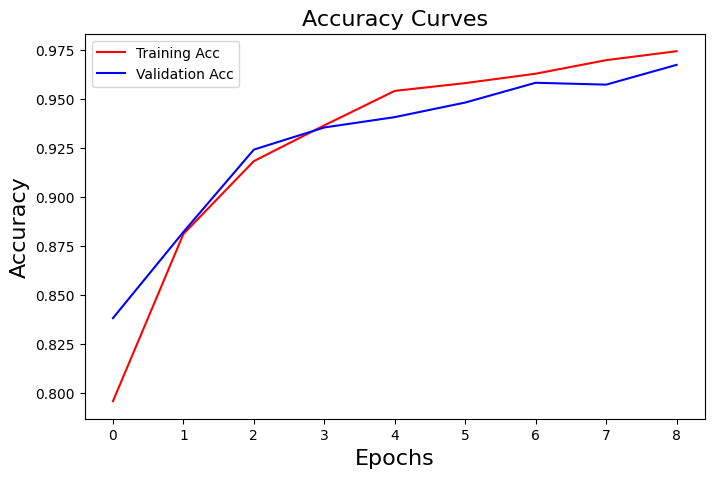

In [140]:
plt.figure(figsize=[8,5])
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.legend(['Training Acc', 'Validation Acc'])
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)

plt.show()

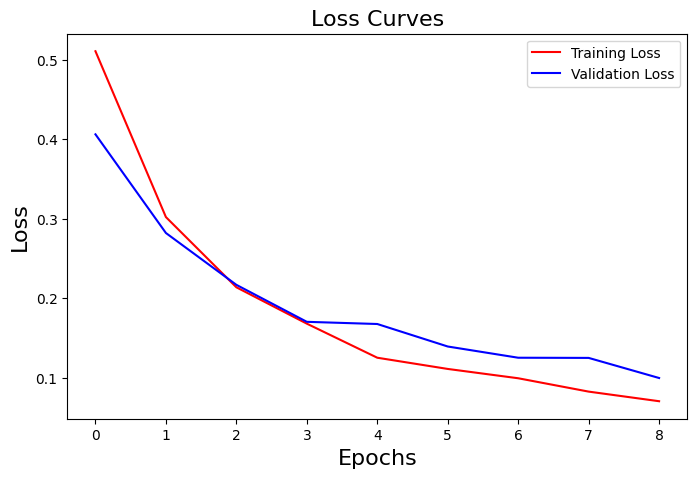

In [141]:
plt.figure(figsize=[8,5])
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)

plt.show()

In [ ]:
# from tensorflow.keras.models import load_model

# # Ganti 'nama_model.h5' dengan nama file H5 yang Anda simpan
# model = load_model('./Result/best_model_without_calm_512.h5')

# # Sekarang model sudah dimuat dan siap digunakan untuk prediksi atau evaluasi


In [142]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_actual = encoder.inverse_transform(y_test)

131/131 [==============================] - 16s 117ms/step


In [143]:
df_pred_vs_actual = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df_pred_vs_actual['Predicted Labels'] = y_pred.flatten()
df_pred_vs_actual['Actual Labels'] = y_actual.flatten()

df_pred_vs_actual.head(15)

,Predicted Labels,Actual Labels
0,happy,happy
1,sad,sad
2,neutral,neutral
3,sad,sad
4,neutral,neutral
5,angry,happy
6,happy,happy
7,happy,happy
8,angry,angry
9,sad,sad


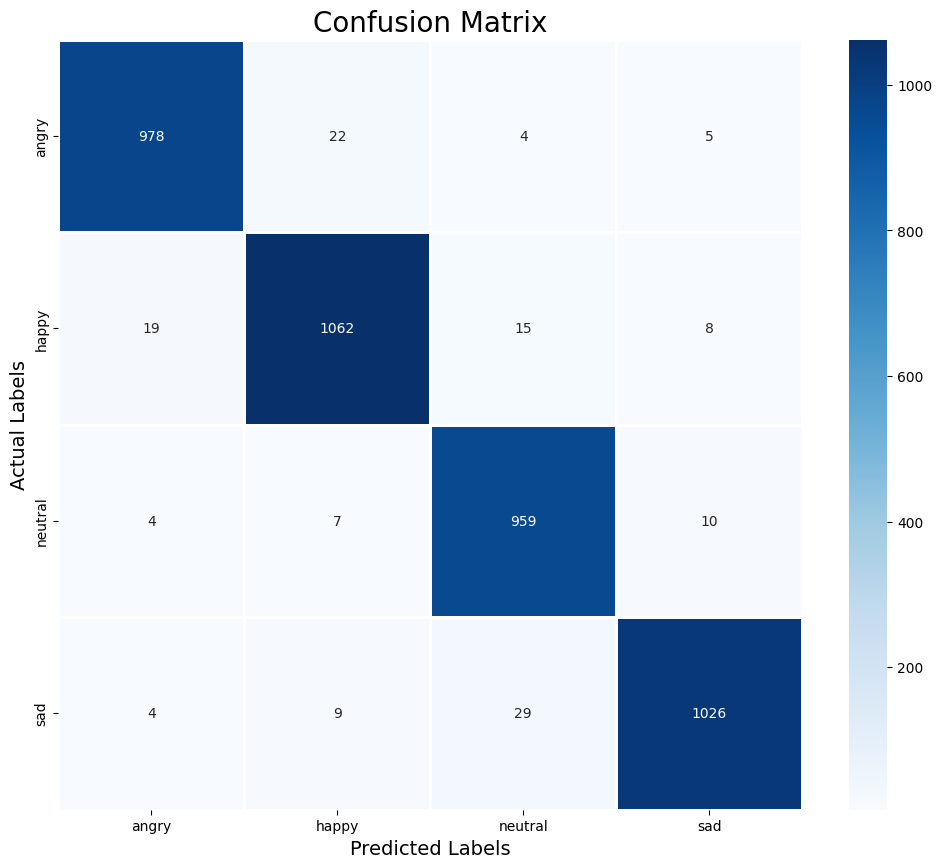

In [144]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_actual, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [145]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")
print(classification_report(y_actual, y_pred))

131/131 [==============================] - 14s 107ms/step - loss: 0.0995 - accuracy: 0.9673
Accuracy of our model on test data :  96.73155546188354 %
              precision    recall  f1-score   support

       angry       0.97      0.97      0.97      1009
       happy       0.97      0.96      0.96      1104
     neutral       0.95      0.98      0.97       980
         sad       0.98      0.96      0.97      1068

    accuracy                           0.97      4161
   macro avg       0.97      0.97      0.97      4161
weighted avg       0.97      0.97      0.97      4161



In [146]:
path = './BU TEJO NGAMUKK.mp3'

feature_test = get_features(path)
test_input = []
for ele in feature_test:
    test_input.append(ele)
    
feat_test = pd.DataFrame(test_input)
test_X = feat_test.values
test_X = scaler.transform(test_X)
test_X = np.expand_dims(test_X, axis=2)

pred_sub = model.predict(test_X, batch_size = 32)
y_sub = encoder.inverse_transform(pred_sub)
classes = y_sub.flatten()[2]

print(classes)    

1/1 [==============================] - 0s 47ms/step
angry


In [ ]:
import os

data_submission = []

path = './Dataset/Test/sadness'

file_list = os.listdir(path)

for audio_name in file_list:
    audio_test = os.path.join(path, audio_name)

    # print(audio_test)
    feature_test = get_features(audio_test)
    test_input = []
    for ele in feature_test:
        test_input.append(ele)
        
    feat_test = pd.DataFrame(test_input)
    test_X = feat_test.values
    test_X = scaler.transform(test_X)
    test_X = np.expand_dims(test_X, axis=2)
    
    pred_sub = model.predict(test_X, batch_size = 32)
    y_sub = encoder.inverse_transform(pred_sub)
    classes = y_sub.flatten()[2]
   
    print(audio_name, classes)    
    data_submission.append((audio_name,classes))

In [150]:
col = ['id', 'value']
df_submission = pd.DataFrame(data_submission, columns=col)
df_submission['value'].value_counts()

value
angry      93
happy      20
neutral     5
sad         3
Name: count, dtype: int64